In [ ]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..")  
from openai import OpenAI
import re
from typing import Optional
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
load_dotenv()
import csv

In [3]:
DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [4]:
ACTIVITY = 'activity'
DEVICE = 'device'
START_TIME = 'start_time'
END_TIME = 'end_time'
TIME = 'time'
VALUE = 'value'
NAME = 'name'

DATASET ='B'

# Initialize DeepSeek client
# api_key = DEEPSEEK_API_KEY  # Your DeepSeek API Key
# client = OpenAI(api_key=api_key, base_url="https://api.deepseek.com")
# model_name = "deepseek-chat"
# MODEL="deepseek"

api_key = OPENAI_API_KEY
client = OpenAI(api_key=api_key)
model_name="gpt-4o-mini-2024-07-18"
MODEL="gpt-4o-mini"
temperature=0


In [5]:
import sys
sys.path.append("..")  
from data_load.load_data import load_ordoneza_dataset_nochange
from pathlib import Path

dataset_b = load_ordoneza_dataset_nochange(Path("../dataset/UCI_ADL_Binary"), part=DATASET)
print(dataset_b['activities'].head())
print(dataset_b['devices'].head())
print(dataset_b.keys())
print(dataset_b['activity_list'])

Corrections applied to OrdonezB activities:
Adjusted Toileting end from 2012-11-14 00:29:59 to 2012-11-14 00:29:00 due to overlap with Sleeping
Adjusted Spare_Time/TV end from 2012-11-14 12:52:59 to 2012-11-14 12:52:00 due to overlap with Leaving
Adjusted Spare_Time/TV end from 2012-11-14 21:37:59 to 2012-11-14 21:37:00 due to overlap with Dinner
Adjusted Spare_Time/TV end from 2012-11-14 22:14:59 to 2012-11-14 22:14:00 due to overlap with Snack
Adjusted Sleeping start from 2012-11-15 00:10:00 to 2012-11-15 00:10:59 due to overlap with Grooming
Adjusted Sleeping end from 2012-11-15 00:43:59 to 2012-11-15 00:43:00 due to overlap with Spare_Time/TV
Adjusted Spare_Time/TV end from 2012-11-17 20:26:59 to 2012-11-17 20:26:00 due to overlap with Snack
Adjusted Spare_Time/TV end from 2012-11-19 21:59:59 to 2012-11-19 21:59:00 due to overlap with Dinner
Adjusted Snack end from 2012-11-19 22:32:59 to 2012-11-19 22:32:00 due to overlap with Spare_Time/TV
Adjusted Leaving end from 2012-11-22 01:4

In [6]:
from data_process.preprocess import convert_events_to_states

state_df = convert_events_to_states(dataset_b['devices'], DATASET)
print(state_df)
# state_df.head(40)

                                          state          start_time  \
0         st(Living-SeatOccupied, 21:14, 00:21) 2012-11-11 21:14:21   
1       st(Living-NearLivingArea, 00:22, 00:22) 2012-11-12 00:22:57   
2     st(Kitchen-NearKitchenArea, 00:23, 00:23) 2012-11-12 00:23:14   
3     st(Kitchen-NearKitchenArea, 00:24, 00:24) 2012-11-12 00:24:20   
4       st(Living-NearLivingArea, 00:24, 00:24) 2012-11-12 00:24:42   
...                                         ...                 ...   
2329  st(Bedroom-NearBedroomArea, 20:41, 20:41) 2012-12-02 20:41:25   
2330    st(Living-NearLivingArea, 20:41, 20:41) 2012-12-02 20:41:44   
2331    st(Living-NearLivingArea, 21:18, 21:18) 2012-12-02 21:18:10   
2332    st(Living-NearLivingArea, 21:18, 21:18) 2012-12-02 21:18:28   
2333      st(Living-SeatOccupied, 21:19, 01:03) 2012-12-02 21:19:12   

                end_time location      type    place                device  
0    2012-11-12 00:21:49     Seat  Pressure   Living  Living_Seat_Pres

In [7]:
def align_sensors_with_activities(sensor_df, activity_df):
    windows_list = []
    activities_list = []
    
    # 假设 sensor_df 包含所有需要的字段
    required_columns = ['state', 'start_time', 'end_time', 'location', 'type', 'place', 'device']
    assert all(col in sensor_df.columns for col in required_columns), "Sensor DataFrame missing required columns"
    
    for _, activity_row in activity_df.iterrows():
        window = sensor_df[
            (sensor_df['start_time'] <= activity_row['end_time']) & 
            (sensor_df['end_time'] >= activity_row['start_time'])
        ].copy()
        
        if not window.empty:
            window_events = window.apply(
                lambda row: {
                    'state': row['state'],
                    'start_time': row['start_time'],
                    'end_time': row['end_time'],
                    'location': row['location'],
                    'type': row['type'],
                    'place': row['place'],
                    'device': row['device']
                }, 
                axis=1
            ).tolist()
            
            windows_list.append(window_events)
            activities_list.append(activity_row['activity'])
    
    return windows_list, activities_list


# 调用函数
windows, activities = align_sensors_with_activities(states_df, dataset_b['activities'])

# 打印结果
print("Windows:")
for i, window in enumerate(windows):
    print(f"Window {i + 1} (Activity: {activities[i]}):")
    for event in window:
        print(f"  {event}")
print("\nActivities:", activities)

Windows:
Window 1 (Activity: relaxing on couch):
  {'state': 'st(Living-SeatOccupied, 21:14, 00:21)', 'start_time': Timestamp('2012-11-11 21:14:21'), 'end_time': Timestamp('2012-11-12 00:21:49'), 'location': 'Seat', 'type': 'Pressure', 'place': 'Living', 'device': 'Living_Seat_Pressure'}
  {'state': 'st(Living-NearLivingArea, 00:22, 00:22)', 'start_time': Timestamp('2012-11-12 00:22:57'), 'end_time': Timestamp('2012-11-12 00:22:59'), 'location': 'Door', 'type': 'PIR', 'place': 'Living', 'device': 'Living_Door_PIR'}
Window 2 (Activity: relaxing on couch):
  {'state': 'st(Kitchen-NearKitchenArea, 00:24, 00:24)', 'start_time': Timestamp('2012-11-12 00:24:20'), 'end_time': Timestamp('2012-11-12 00:24:22'), 'location': 'Door', 'type': 'PIR', 'place': 'Kitchen', 'device': 'Kitchen_Door_PIR'}
  {'state': 'st(Living-NearLivingArea, 00:24, 00:24)', 'start_time': Timestamp('2012-11-12 00:24:42'), 'end_time': Timestamp('2012-11-12 00:24:54'), 'location': 'Door', 'type': 'PIR', 'place': 'Living', 

In [8]:
import pandas as pd
import os
import csv


def save_results(windows, activities, output_dir='best_predict_B/windows', activities_file='best_predict_B/activities.txt'):
    # 创建输出目录（如果不存在）
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # 保存活动到TXT文件
    with open(activities_file, 'w') as f:
        for activity in activities:
            f.write(f"{activity}\n")
    
    # 保存每个窗口到单独的TXT文件
    fieldnames = ['state', 'start_time', 'end_time', 'location', 'type', 'place', 'device']
    for i, window in enumerate(windows, 1):
        window_file = os.path.join(output_dir, f'window_{i}.csv')
        with open(window_file, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(window)

# 保存到文件
save_results(windows, activities)

print("Data has been saved to files.")

Data has been saved to files.


In [12]:
import os
import pandas as pd
from pathlib import Path
import re

def load_dataframes_from_files(folder_path=f'best_predict_B/windows'):
    """
    从指定文件夹加载所有窗口文件，并按数字顺序返回 DataFrame 列表。
    """
    dataframes = []
    folder = Path(folder_path)

    if folder.exists():
        files = list(folder.glob('window_*.csv'))  # 获取所有窗口文件列表

        # 使用正则表达式提取文件名中的数字，并进行排序
        def get_window_number(file_path):
            match = re.search(r'window_(\d+)\.csv', str(file_path))
            return int(match.group(1)) if match else 0

        sorted_files = sorted(files, key=get_window_number)

        for file_path in sorted_files:
            try:
                df = pd.read_csv(file_path)
                dataframes.append(df)
            except Exception as e:
                print(f"警告：加载文件 {file_path} 时出错：{e}")
    else:
        print(f"警告：文件夹 {folder_path} 不存在。")

    return dataframes

# 加载 DataFrame
loaded_dataframes = load_dataframes_from_files()

# 打印前五个加载的 DataFrame（可选）
if loaded_dataframes:
    for i, df in enumerate(loaded_dataframes):
        if i < 5: 
            print(f"DataFrame {i + 1}:")
            print(df.head())
            print("-" * 20)
        else:
            break  # 停止循环

DataFrame 1:
                                     state           start_time  \
0    st(Living-SeatOccupied, 21:14, 00:21)  2012-11-11 21:14:21   
1  st(Living-NearLivingArea, 00:22, 00:22)  2012-11-12 00:22:57   

              end_time location      type   place                device  
0  2012-11-12 00:21:49     Seat  Pressure  Living  Living_Seat_Pressure  
1  2012-11-12 00:22:59     Door       PIR  Living       Living_Door_PIR  
--------------------
DataFrame 2:
                                       state           start_time  \
0  st(Kitchen-NearKitchenArea, 00:24, 00:24)  2012-11-12 00:24:20   
1    st(Living-NearLivingArea, 00:24, 00:24)  2012-11-12 00:24:42   
2      st(Living-SeatOccupied, 00:25, 00:42)  2012-11-12 00:25:35   
3    st(Living-NearLivingArea, 00:43, 00:43)  2012-11-12 00:43:46   

              end_time location      type    place                device  
0  2012-11-12 00:24:22     Door       PIR  Kitchen      Kitchen_Door_PIR  
1  2012-11-12 00:24:54     Door  


    The data comes from an event-based time window starting around 9:14 PM.
    Here is the list of recorded events:
    [{'state': 'Living-SeatOccupied', 'place': 'living', 'location': 'seat', 'type': 'pressure', 'device': 'living_seat_pressure', 'duration': 11248, 'start_time': '9:14 PM', 'end_time': '12:21 AM'}, {'state': 'Living-NearLivingArea', 'place': 'living', 'location': 'door', 'type': 'pir', 'device': 'living_door_pir', 'duration': 2, 'start_time': '12:22 AM', 'end_time': '12:22 AM'}]
    
    Please generate a natural language description based on these events, following these guidelines:
    - Start with "Around 9:14 PM, ".
    - Indicate the subject's location and describe their activities based on the state, place, and device information.
    - Use connecting words (like "then", "while", or "after") to make the description flow smoothly.
    - Incorporate approximate times (start_time) where relevant to provide a sense of sequence.
    
Window 1:
Description: Around 9:1

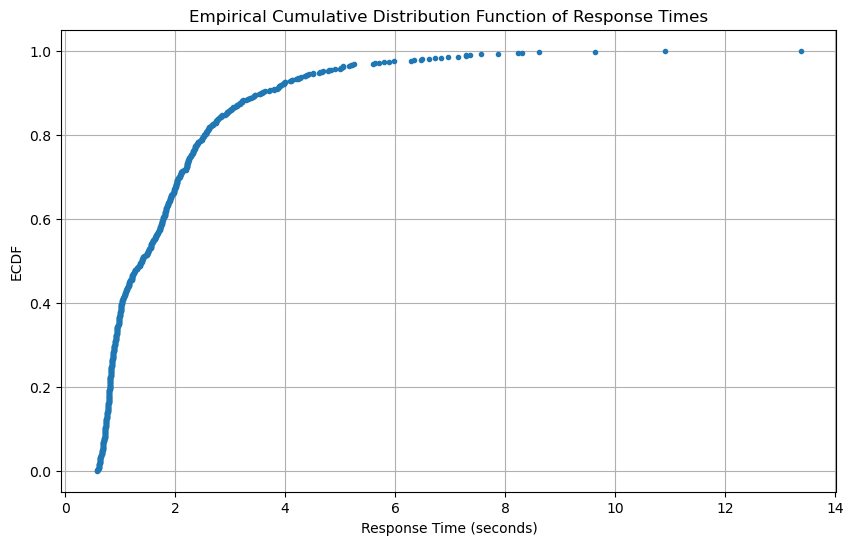

ECDF plot saved to: best_predict_B/response_time_ecdf.png


In [10]:
import pandas as pd
from datetime import timedelta
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional
import re
import os

# Function 1: Generate natural language descriptions with token and time tracking
def generate_natural_language_description(df):
    """
    Convert sensor state data into a natural language description using LLM.
    Tracks token usage and response time. Adapted for event-based windows without activity column.
    """
    # 确保时间列是 datetime 类型
    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])
    
    # 获取窗口的起始和结束时间
    window_start = df['start_time'].min()
    window_end = df['end_time'].max()
    window_time_str = window_start.strftime('%I:%M %p').lstrip('0')
    
    # 按开始时间排序
    df = df.sort_values('start_time')
    
    # 生成事件列表
    events = []
    for _, row in df.iterrows():
        # 从 state 中提取状态名称 (e.g., Kitchen-FridgeDoorOpen)
        state_name = row['state'].split('(')[1].split(',')[0] if '(' in row['state'] else row['state']
        duration = (row['end_time'] - row['start_time']).total_seconds()
        event = {
            'state': state_name,
            'place': row['place'].lower(),
            'location': row['location'].lower(),
            'type': row['type'].lower(),
            'device': row['device'].lower(),
            'duration': int(duration) if duration > 0 else 1,
            'start_time': row['start_time'].strftime('%I:%M %p').lstrip('0'),
            'end_time': row['end_time'].strftime('%I:%M %p').lstrip('0')
        }
        events.append(event)
    
    # 构造提示词（去掉 activity 相关内容）
    prompt = f"""
    The data comes from an event-based time window starting around {window_time_str}.
    Here is the list of recorded events:
    {events}
    
    Please generate a natural language description based on these events, following these guidelines:
    - Start with "Around {window_time_str}, ".
    - Indicate the subject's location and describe their activities based on the state, place, and device information.
    - Use connecting words (like "then", "while", or "after") to make the description flow smoothly.
    - Incorporate approximate times (start_time) where relevant to provide a sense of sequence.
    """

    print(prompt)
    
    try:
        start_time = time.time()
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "You are a helpful intelligent assistant tasked with converting sensor data into smooth, natural English descriptions"},
                {"role": "user", "content": prompt}
            ],
            max_tokens=500,
            temperature=0.0
        )
        end_time = time.time()
        
        response_time = end_time - start_time
        tokens_used = response.usage.total_tokens if hasattr(response, 'usage') else 0
        
        return {
            'description': response.choices[0].message.content.strip(),
            'response_time': response_time,
            'tokens_used': tokens_used
        }
    except Exception as e:
        return {
            'description': f"Error generating description: {str(e)}",
            'response_time': 0,
            'tokens_used': 0
        }

# Function 2: Classify a single description with token and time tracking
def classify_single_activity(description):
    system_prompt = """
    Act as a human activity recognition system that infers the activities performed by a subject in their home.
    The home has the following locations: 'bathroom', 'bedroom', 'kitchen', and 'living room', and 'entrance (main door)'
    The system captures the subject's interactions with: Shower, Basin, Cooktop, Maindoor, Fridge, Cabinet, Cupboard, Toilet, Microwave, Seat, Bed, Toaster.
    I will provide you with a description of what happened during a specific time window, and your goal is to provide the most likely activity.
    The possible activities are: sleeping,showering,preparing breakfast,personal care,relaxing on couch,leaving home,preparing lunch,preparing dinner,snacking
    Your answer should be only one activity using the following format: ACTIVITY=(activity name)
    """
    
    try:
        start_time = time.time()
        response = client.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": description}
            ],
            stream=False,
            temperature=0.0
        )
        end_time = time.time()
        
        response_time = end_time - start_time
        tokens_used = response.usage.total_tokens if hasattr(response, 'usage') else 0
        
        activity_str = response.choices[0].message.content.strip()
        activity_label = extract_activity_label(activity_str)
        
        return {
            'activity': activity_label if activity_label else "Unknown",
            'response_time': response_time,
            'tokens_used': tokens_used
        }
    except Exception as e:
        return {
            'activity': f"Error: {str(e)}",
            'response_time': 0,
            'tokens_used': 0
        }

# Helper function to extract activity label
def extract_activity_label(response: str) -> Optional[str]:
    """Extract the activity label from the model response."""
    match = re.search(r"ACTIVITY=(.*)", response)
    if match:
        return match.group(1).strip()
    return None

# Modified pipeline execution with tracking and ECDF plotting
def run_pipeline(windows, desc_output_path=f'best_predict_B/descriptions_{DATASET}.txt', 
                 label_output_path=f'best_predict_B/predictions_{DATASET}.txt',
                 metrics_output_path=f'best_predict_B/metrics_{DATASET}.txt'):
    """
    Run the pipeline: generate description, classify it, track metrics, and plot ECDF of response times.
    """
    os.makedirs(os.path.dirname(desc_output_path), exist_ok=True)
    
    response_times = []
    total_tokens = 0
    all_tokens = []

    with open(desc_output_path, 'w', encoding='utf-8') as desc_file, \
         open(label_output_path, 'w', encoding='utf-8') as label_file, \
         open(metrics_output_path, 'w', encoding='utf-8') as metrics_file:
        
        for idx, window in enumerate(windows):
            # Step 1: Generate description
            desc_result = generate_natural_language_description(window)
            description = desc_result['description']
            desc_time = desc_result['response_time']
            desc_tokens = desc_result['tokens_used']
            
            # Step 2: Classify the description
            class_result = classify_single_activity(description)
            activity_label = class_result['activity']
            class_time = class_result['response_time']
            class_tokens = class_result['tokens_used']
            
            # Track metrics
            response_times.extend([desc_time, class_time])
            total_tokens += desc_tokens + class_tokens
            all_tokens.extend([desc_tokens, class_tokens])

            # Print results
            print(f"Window {idx + 1}:")
            print(f"Description: {description}")
            print(f"Classified Activity: {activity_label}")
            print(f"Description Time: {desc_time:.2f}s, Tokens: {desc_tokens}")
            print(f"Classification Time: {class_time:.2f}s, Tokens: {class_tokens}\n")
            
            # Save to files
            desc_file.write(f"{description}\n")
            label_file.write(f"{activity_label}\n")
            metrics_file.write(f"Window {idx + 1}:\n")
            metrics_file.write(f"Description Time: {desc_time:.2f}s, Tokens: {desc_tokens}\n")
            metrics_file.write(f"Classification Time: {class_time:.2f}s, Tokens: {class_tokens}\n\n")

        print(f"\nTotal windows processed: {len(windows)}")
        print(f"Total tokens used: {total_tokens}")
        print(f"Descriptions saved to: {desc_output_path}")
        print(f"Activity labels saved to: {label_output_path}")
        print(f"Metrics saved to: {metrics_output_path}") # 添加了metrics的保存路径输出

        # Save all tokens to the metrics file
        # metrics_file.write("\nAll tokens used (description, classification):\n")
        # for tokens in all_tokens:
        #     metrics_file.write(f"{tokens}\n")

    # Generate and plot ECDF
    plot_ecdf(response_times)

def plot_ecdf(response_times):
    """Generate and display ECDF plot of response times."""
    sorted_times = np.sort(response_times)
    y = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    
    plt.figure(figsize=(10, 6))
    plt.plot(sorted_times, y, marker='.', linestyle='none')
    plt.xlabel('Response Time (seconds)')
    plt.ylabel('ECDF')
    plt.title('Empirical Cumulative Distribution Function of Response Times')
    plt.grid(True)
    
    # Save plot
    plot_path = f'best_predict_B/response_time_ecdf.png'
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    plt.savefig(plot_path)
    plt.show()
    print(f"ECDF plot saved to: {plot_path}")

# Run the pipeline
test = loaded_dataframes.copy()
run_pipeline(test)

In [16]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import os
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_predictions_split_activities(true_labels_file, predicted_labels_file, output_file=f'best_predict_B/evaluation_{DATASET}.txt'):
    """
    评估预测标签，拆分窗口中的多个活动，并输出每个类别的 F1 分数和混淆矩阵图像。
    """
    try:
        with open(true_labels_file, 'r') as f:
            true_labels_raw = [line.strip() for line in f]

        with open(predicted_labels_file, 'r') as f:
            predicted_labels_raw = [line.strip() for line in f]

        if len(true_labels_raw) != len(predicted_labels_raw):
            raise ValueError("真实标签的数量与预测标签的数量不匹配。")

        true_labels_split = [label.split(',') for label in true_labels_raw]
        predicted_labels_split = [label.split(',') for label in predicted_labels_raw]

        true_labels_split = [[label.strip() for label in sublist] for sublist in true_labels_split]
        predicted_labels_split = [[label.strip() for label in sublist] for sublist in predicted_labels_split]

        all_true_labels = []
        all_predicted_labels = []

        for true_labels, predicted_labels in zip(true_labels_split, predicted_labels_split):
            all_true_labels.extend(true_labels)
            all_predicted_labels.extend(predicted_labels)

        unique_labels = sorted(list(set(all_true_labels + all_predicted_labels)))

        y_true = []
        y_pred = []

        for true_labels, predicted_labels in zip(true_labels_split, predicted_labels_split):
            temp_true = []
            temp_pred = []
            for label in unique_labels:
                if label in true_labels:
                    temp_true.append(1)
                else:
                    temp_true.append(0)
                if label in predicted_labels:
                    temp_pred.append(1)
                else:
                    temp_pred.append(0)
            y_true.append(temp_true)
            y_pred.append(temp_pred)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 归一化混淆矩阵

        with open(output_file, 'w') as output:
            output.write("Classification Report:\n")
            output.write(classification_report(y_true, y_pred, target_names=unique_labels))

            output.write("\nConfusion Matrix:\n")
            output.write(np.array2string(cm))

            f1_macro = f1_score(y_true, y_pred, average='macro')
            output.write(f"\nF1 Macro Score: {f1_macro}\n")

            f1_weighted = f1_score(y_true, y_pred, average='weighted')
            output.write(f"Weighted F1 Score: {f1_weighted}\n") # 添加加权F1

            f1_per_class = f1_score(y_true, y_pred, average=None)
            output.write("\nF1 Score per Class:\n")
            for i, label in enumerate(unique_labels):
                output.write(f"  {label}: {f1_per_class[i]}\n")

        # 绘制混淆矩阵图像
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Normalized Confusion Matrix')
        plt.tight_layout()

        # 保存混淆矩阵图像
        plot_path = f'best_predict_B/confusion_matrix_{DATASET}.png'
        os.makedirs(os.path.dirname(plot_path), exist_ok=True)
        plt.savefig(plot_path)
        plt.close()

        print(f"拆分活动后的评估结果已保存到 {output_file} 和 {plot_path}")

    except FileNotFoundError:
        print("Error: 文件未找到。")
    except ValueError as e:
        print(f"Error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# 示例用法
true_labels_file = f'best_predict_B/truth_labels_{DATASET}.txt'
predicted_labels_file = f'best_predict_B/predictions_{DATASET}.txt'
output_file = f'best_predict_B/output_{DATASET}.txt'

evaluate_predictions_split_activities(true_labels_file, predicted_labels_file, output_file)

拆分活动后的评估结果已保存到 best_predict_B/output_B.txt 和 best_predict_B/confusion_matrix_B.png


In [ ]:
# import numpy as np
# from sklearn.metrics import classification_report, confusion_matrix, f1_score
# import os
# import matplotlib.pyplot as plt
# import seaborn as sns

# def evaluate_predictions_split_activities(true_labels_file, predicted_labels_file, output_file=f'best_predict_B/evaluation_{DATASET}.txt'):
#     """
#     评估预测标签，拆分窗口中的多个活动，并输出每个类别的 F1 分数和混淆矩阵图像。
#     """
#     try:
#         with open(true_labels_file, 'r') as f:
#             true_labels_raw = [line.strip() for line in f]

#         with open(predicted_labels_file, 'r') as f:
#             predicted_labels_raw = [line.strip() for line in f]

#         if len(true_labels_raw) != len(predicted_labels_raw):
#             raise ValueError("真实标签的数量与预测标签的数量不匹配。")

#         true_labels_split = [label.split(',') for label in true_labels_raw]
#         predicted_labels_split = [label.split(',') for label in predicted_labels_raw]

#         true_labels_split = [[label.strip() for label in sublist] for sublist in true_labels_split]
#         predicted_labels_split = [[label.strip() for label in sublist] for sublist in predicted_labels_split]

#         all_true_labels = []
#         all_predicted_labels = []

#         for true_labels, predicted_labels in zip(true_labels_split, predicted_labels_split):
#             all_true_labels.extend(true_labels)
#             all_predicted_labels.extend(predicted_labels)

#         unique_labels = sorted(list(set(all_true_labels + all_predicted_labels)))

#         y_true = []
#         y_pred = []

#         for true_labels, predicted_labels in zip(true_labels_split, predicted_labels_split):
#             temp_true = []
#             temp_pred = []
#             for label in unique_labels:
#                 if label in true_labels:
#                     temp_true.append(1)
#                 else:
#                     temp_true.append(0)
#                 # 修改标签比较逻辑
#                 if label in predicted_labels:
#                     temp_pred.append(1)
#                 else:
#                     temp_pred.append(0)
#             y_true.append(temp_true)
#             y_pred.append(temp_pred)

#         y_true = np.array(y_true)
#         y_pred = np.array(y_pred)

#         # 修改混淆矩阵计算逻辑
#         true_labels_single = []
#         predicted_labels_single = []
#         for i in range(len(y_true)):
#             true_labels_single.append(np.argmax(y_true[i]))
#             predicted_labels_single.append(np.argmax(y_pred[i]))

#         cm = confusion_matrix(true_labels_single, predicted_labels_single)
#         cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 归一化混淆矩阵

#         with open(output_file, 'w') as output:
#             output.write("Classification Report:\n")
#             output.write(classification_report(true_labels_single, predicted_labels_single, target_names=unique_labels))

#             output.write("\nConfusion Matrix:\n")
#             output.write(np.array2string(cm))

#             f1_macro = f1_score(true_labels_single, predicted_labels_single, average='macro')
#             output.write(f"\nF1 Macro Score: {f1_macro}\n")

#             f1_per_class = f1_score(true_labels_single, predicted_labels_single, average=None)
#             output.write("\nF1 Score per Class:\n")
#             for i, label in enumerate(unique_labels):
#                 output.write(f"  {label}: {f1_per_class[i]}\n")

#         # 绘制混淆矩阵图像
#         plt.figure(figsize=(10, 8))
#         sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
#         plt.xlabel('Predicted Labels')
#         plt.ylabel('True Labels')
#         plt.title('Normalized Confusion Matrix')
#         plt.tight_layout()

#         # 保存混淆矩阵图像
#         plot_path = f'best_predict_B/confusion_matrix_{DATASET}.png'
#         os.makedirs(os.path.dirname(plot_path), exist_ok=True)
#         plt.savefig(plot_path)
#         plt.close()

#         print(f"拆分活动后的评估结果已保存到 {output_file} 和 {plot_path}")

#     except FileNotFoundError:
#         print("Error: 文件未找到。")
#     except ValueError as e:
#         print(f"Error: {e}")
#     except Exception as e:
#         print(f"An unexpected error occurred: {e}")

# # 示例用法
# true_labels_file = f'best_predict_B/truth_labels_{DATASET}.txt'
# predicted_labels_file = f'best_predict_B/predictions_{DATASET}.txt'
# output_file = f'best_predict_B/output_{DATASET}.txt'

# evaluate_predictions_split_activities(true_labels_file, predicted_labels_file, output_file)

C:\Users\leave\AppData\Local\Temp\ipykernel_6748\3780301688.py:66: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 归一化混淆矩阵
d:\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\anaconda3\envs\thesis\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true sam

拆分活动后的评估结果已保存到 LLM_gpt-4o-mini_A_60s_7/output_A_60s.txt 和 LLM_gpt-4o-mini_A_60s_7/confusion_matrix_A_60s.png
